In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import re
from sklearn import datasets, linear_model
import seaborn as sns
from matplotlib import cm
from scipy.stats import wilcoxon,sem

from entropy_estimators import continuous

In [2]:
def get_normalized_mean_amplitude_hwhm_per_epoch(peak_hwhm_csv_list):
    cum_peak_hwhm_dataframe_output = pd.DataFrame (columns = ['epoch','hwhm','amplitude','population'])    
    
    for file in peak_hwhm_csv_list:
        test_df = pd.read_csv(file)
        epochs = test_df['epoch'].drop_duplicates()
        epochs = epochs.to_list()

        populations = ['L2/3']
        populations_multiindex = np.repeat(populations,len(epochs))

        epochs_multiindex = np.tile(epochs,1)

        multiindex_plot = pd.MultiIndex.from_arrays([populations_multiindex,epochs_multiindex],names=('population', 'epoch') )

        for i,measure in enumerate(['amplitude','hwhm']):

            mean_s = test_df.set_index('epoch').groupby(['population', 'epoch'])[measure].mean()
            mean_s = mean_s.reindex(multiindex_plot)
            
            mean_df = mean_s.to_frame()
            mean_df = mean_df.reset_index()

            if measure == 'amplitude': 
                mean_amplitude_df = mean_df
            if measure == 'hwhm': 
                mean_hwhm_df = mean_df

        mean_hwhm_df = mean_hwhm_df.loc[mean_hwhm_df['population']=='L2/3']
        mean_amplitude_df = mean_amplitude_df.loc[mean_amplitude_df['population']=='L2/3']
        
        #Normalize to 'Only L4'
        mean_hwhm_L4input = mean_hwhm_df.hwhm.loc[mean_hwhm_df['epoch']=='Only L4 input'].values
        mean_hwhm_df.hwhm = mean_hwhm_df.hwhm/mean_hwhm_L4input
        mean_amplitude_L4input = mean_amplitude_df.amplitude.loc[mean_amplitude_df['epoch']=='Only L4 input'].values
        mean_amplitude_df.amplitude = mean_amplitude_df.amplitude/mean_amplitude_L4input
        
        mean_hwhm_df['amplitude'] = mean_amplitude_df['amplitude']
        cum_peak_hwhm_dataframe_temp = mean_hwhm_df 
        
        cum_peak_hwhm_dataframe_output = cum_peak_hwhm_dataframe_output.append(cum_peak_hwhm_dataframe_temp)    
    
    
    return cum_peak_hwhm_dataframe_output



In [3]:
parent_folder = '/Users/alexvourvoukelis/Desktop/DTP_rotation_2/Code/L5/simulations'

simulation_dirs = []
peak_hwhm_files = []
for root, directories, files in os.walk(parent_folder, topdown=False):
    for name in files:
        if 'population_peaks' in name:
            peak_hwhm_files.append(os.path.join(root, name))
    for name in directories:
        if 'temporaloffset' in name:
            simulation_dirs.append(os.path.join(root, name))
            

In [4]:
peak_hwhm_files_homogeneous_synch = []

for file in peak_hwhm_files:
    if 'homogeneous' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'asynchronous' not in file:
                    if 'test' in file:
                        peak_hwhm_files_homogeneous_synch.append(file)
peak_hwhm_files_homogeneous_synch.sort()

peak_hwhm_files_homogeneous_asynch = []

for file in peak_hwhm_files:
    if 'homogeneous' in file:
        if '200ms' in file:
            if 'asynchronous' in file:
                if 'test' in file:
                    peak_hwhm_files_homogeneous_asynch.append(file)
peak_hwhm_files_homogeneous_asynch.sort()

peak_hwhm_files_discrete_synch = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'asynchronous' not in file:
                    if 'test' in file:
                        peak_hwhm_files_discrete_synch.append(file)
peak_hwhm_files_discrete_synch.sort()

peak_hwhm_files_discrete_asynch = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'asynchronous' in file:
                if 'test' in file:
                    peak_hwhm_files_discrete_asynch.append(file)
peak_hwhm_files_discrete_asynch.sort()

peak_hwhm_files_discrete_synch_varstr = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'varyingstrength' in file:
                    if 'asynchronous' not in file:
                        peak_hwhm_files_discrete_synch_varstr.append(file)
peak_hwhm_files_discrete_synch_varstr.sort()

peak_hwhm_files_discrete_asynch_varstr = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'asynchronous' in file:
                if 'varyingstrength' in file:
                    peak_hwhm_files_discrete_asynch_varstr.append(file)
peak_hwhm_files_discrete_asynch_varstr.sort()


In [5]:
iter_values = []
for file in peak_hwhm_files_discrete_asynch:
    match = re.search('iter\d', file)
    if match and match.group() not in iter_values:
        iter_values.append(match.group())

In [7]:
all_files = {'homogeneous_synchronous': peak_hwhm_files_homogeneous_synch,
             'homogeneous_asynchronous': peak_hwhm_files_homogeneous_asynch,
             'discrete_synchronous': peak_hwhm_files_discrete_synch,
             'discrete_asynchronous': peak_hwhm_files_discrete_asynch}
#              'discrete_synchronous_varyingstrength': peak_hwhm_files_discrete_synch_varstr,
#              'discrete_asynchronous_varyingstrength': peak_hwhm_files_discrete_asynch_varstr}

### Separate by simulation

In [8]:
all_files_separated = dict()

for simulation_label in all_files:
    iter_values = []
    for file in all_files[simulation_label]:
        iter_substring = re.search('iter\d', file)
        if iter_substring and iter_substring.group() not in iter_values:
            iter_values.append(iter_substring.group())
            
    all_files_separated[simulation_label] = dict() 

    for iter_label in iter_values:
        all_files_separated[simulation_label][iter_label] = [file for file in all_files[simulation_label] if iter_label in file] 
        

### Unpack and normalize data in both data storage formats

In [9]:
all_data_pooled = dict()
for label in all_files:
    all_data_pooled[label] = get_normalized_mean_amplitude_hwhm_per_epoch(all_files[label])
    all_data_pooled[label] = all_data_pooled[label].dropna()
    all_data_pooled[label] = all_data_pooled[label].reset_index()


In [10]:
# print(len(all_data_separated['homogeneous_asynchronous']['iter0']))# - len(all_data_separated['homogeneous_asynchronous']['iter0']))

In [11]:
all_data_separated = dict()
for label in all_files_separated:
    all_data_separated[label] = dict()
    for iter_label in all_files_separated[label]:
        all_data_separated[label][iter_label] =  get_normalized_mean_amplitude_hwhm_per_epoch(all_files_separated[label][iter_label])
        all_data_separated[label][iter_label] = all_data_separated[label][iter_label].dropna()
        all_data_separated[label][iter_label] = all_data_separated[label][iter_label].reset_index()

In [12]:
pd.set_option('display.max_rows', None)

# all_data_pooled['discrete_asynchronous_varyingstrength'][['hwhm','amplitude']].max()

### Subsample and calculate entropy

In [13]:
len_hom_asynch = []
for simulation in all_data_separated['homogeneous_asynchronous']:
    len_hom_asynch.append(len(all_data_separated['homogeneous_asynchronous'][simulation].drop_duplicates(subset=['hwhm','amplitude'])))
len_hom_asynch  

[211, 211, 211, 211, 211, 210, 211, 211, 211]

In [14]:
average_entropy_per_sim_hom = []

for simulation in all_data_separated['homogeneous_asynchronous']:
    temp_simulation_samples_hwhm_ampl = all_data_separated['homogeneous_asynchronous'][simulation].drop_duplicates(subset=['hwhm','amplitude'])
    temp_simulation_samples_hwhm_ampl = temp_simulation_samples_hwhm_ampl[['hwhm','amplitude']]
    temp_simulation_samples_hwhm_ampl = temp_simulation_samples_hwhm_ampl.loc[(temp_simulation_samples_hwhm_ampl.hwhm!=1) & (temp_simulation_samples_hwhm_ampl.amplitude!=1)]

    entropy_temp = continuous.get_h(temp_simulation_samples_hwhm_ampl.to_numpy(),k=15)
    average_entropy_per_sim_hom.append(entropy_temp)

        
average_entropy_per_sim_hom


[-0.6871639668632952,
 -0.611764501894005,
 -0.7201924249174874,
 -0.6662943742322427,
 -0.707640031612907,
 -0.6929361757724135,
 -0.693528096358488,
 -0.707622830888726,
 -0.49249685753293315]

In [15]:
average_entropy_per_sim_dis = []

for simulation in all_data_separated['discrete_asynchronous']:
    temp_simulation_samples_hwhm_ampl = all_data_separated['discrete_asynchronous'][simulation].drop_duplicates(subset=['hwhm','amplitude'])
    temp_simulation_samples_hwhm_ampl = temp_simulation_samples_hwhm_ampl[['hwhm','amplitude']]
    temp_simulation_samples_hwhm_ampl = temp_simulation_samples_hwhm_ampl.loc[(temp_simulation_samples_hwhm_ampl.hwhm!=1) & (temp_simulation_samples_hwhm_ampl.amplitude!=1)]

    
    temp_entropy_all = []
    for i in np.arange(0,100,1):
        subsample_idx_temp = np.random.randint(len(temp_simulation_samples_hwhm_ampl),size=211)
        subsample_temp = temp_simulation_samples_hwhm_ampl.to_numpy()
        subsample_temp = subsample_temp[subsample_idx_temp]
        entropy_temp = continuous.get_h(subsample_temp,k=15)
        temp_entropy_all.append(entropy_temp)
    average_entropy_per_sim_dis.append(np.mean(temp_entropy_all))

        
average_entropy_per_sim_dis


[0.07431729264453278,
 0.010939303507166969,
 -0.06135467276573138,
 -0.06828605045075245,
 -0.0334901816237269,
 -0.01201457035840349,
 -0.011354402596796636,
 0.48799809164069763,
 0.3478114355970864]

In [16]:
print('BOTH HWHM AND AMPLITUDE\n')
print(''.join(('Mean hom:',str(np.mean(average_entropy_per_sim_hom)),' sem: ' ,str(sem(average_entropy_per_sim_hom)))))
print(''.join(('Mean dis:',str(np.mean(average_entropy_per_sim_dis)),' sem: ' ,str(sem(average_entropy_per_sim_dis)))))
print(''.join(('Entropy diff:',str(np.mean(average_entropy_per_sim_dis-np.mean(average_entropy_per_sim_hom))))))



wilcoxon(average_entropy_per_sim_hom,average_entropy_per_sim_dis)

BOTH HWHM AND AMPLITUDE

Mean hom:-0.6644043622302775 sem: 0.02396653922312543
Mean dis:0.08161847173267477 sem: 0.06610447658329253
Entropy diff:0.7460228339629524


WilcoxonResult(statistic=0.0, pvalue=0.00390625)

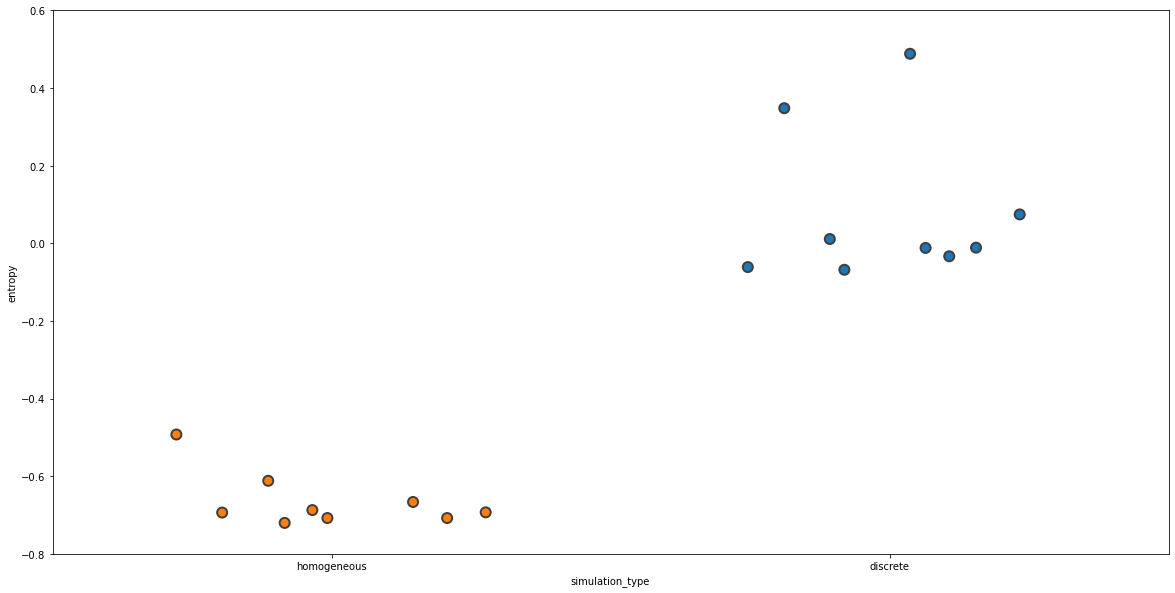

In [17]:
entropy_per_simulation_type = pd.DataFrame({'entropy':np.concatenate((average_entropy_per_sim_hom,average_entropy_per_sim_dis)),
                                            'simulation_type':np.concatenate((np.repeat('homogeneous',9),np.repeat('discrete',9)))
                                           } )

fig = plt.figure(figsize = (20,10))

ax = sns.stripplot(x = 'simulation_type', 
                   y = 'entropy', 
                   palette=["C1", "C0"],
                   data=entropy_per_simulation_type,
                   jitter=0.3,
                   size=10,
                   linewidth=2
                   
                  )

ax.set_ylim(-0.8,0.6)

fig.savefig("/".join((parent_folder,'cumulative_plots','entropy_asynchronous_all_norm_hwhm_amplitude_scatter.pdf')))

### Amplitude only

In [18]:
average_entropy_per_sim_hom = []

for simulation in all_data_separated['homogeneous_asynchronous']:
    temp_simulation_samples__ampl = all_data_separated['homogeneous_asynchronous'][simulation].drop_duplicates(subset=['amplitude'])
    temp_simulation_samples__ampl = temp_simulation_samples__ampl[['amplitude']]
    temp_simulation_samples__ampl = temp_simulation_samples__ampl.loc[temp_simulation_samples__ampl.amplitude!=1]

    entropy_temp = continuous.get_h(temp_simulation_samples__ampl.to_numpy(),k=15)
    average_entropy_per_sim_hom.append(entropy_temp)

        
average_entropy_per_sim_hom


[-0.25458529411109554,
 -0.21555957527685088,
 -0.3478797191453218,
 -0.28752295851291754,
 -0.29114808672944514,
 -0.37172467691480726,
 -0.21816877801928314,
 -0.2706816578136708,
 -0.22744540157426796]

In [19]:
average_entropy_per_sim_dis = []

for simulation in all_data_separated['discrete_asynchronous']:
    temp_simulation_samples__ampl = all_data_separated['discrete_asynchronous'][simulation].drop_duplicates(subset=['amplitude'])
    temp_simulation_samples__ampl = temp_simulation_samples__ampl[['amplitude']]
    temp_simulation_samples__ampl = temp_simulation_samples__ampl.loc[temp_simulation_samples__ampl.amplitude!=1]

    
    temp_entropy_all = []
    for i in np.arange(0,100,1):
        subsample_idx_temp = np.random.randint(len(temp_simulation_samples__ampl),size=211)
        subsample_temp = temp_simulation_samples__ampl.to_numpy()
        subsample_temp = subsample_temp[subsample_idx_temp]
        entropy_temp = continuous.get_h(subsample_temp,k=15)
        temp_entropy_all.append(entropy_temp)
    average_entropy_per_sim_dis.append(np.mean(temp_entropy_all))

        
average_entropy_per_sim_dis


[0.08042235658038344,
 0.11202692253577747,
 0.07383809597212229,
 0.10060804508217312,
 0.04959648518244784,
 0.1347866270952081,
 0.11558307701670437,
 0.3899763704664434,
 0.300811109036731]

In [20]:
print('AMPLITUDE ONLY\n')
print(''.join(('Mean hom:',str(np.mean(average_entropy_per_sim_hom)),' sem: ' ,str(sem(average_entropy_per_sim_hom)))))
print(''.join(('Mean dis:',str(np.mean(average_entropy_per_sim_dis)),' sem: ' ,str(sem(average_entropy_per_sim_dis)))))
print(''.join(('Entropy diff:',str(np.mean(average_entropy_per_sim_dis-np.mean(average_entropy_per_sim_hom))))))

wilcoxon(average_entropy_per_sim_hom,average_entropy_per_sim_dis)

AMPLITUDE ONLY

Mean hom:-0.2760795720108511 sem: 0.0184594196484946
Mean dis:0.1508498987742212 sem: 0.038432153249081336
Entropy diff:0.4269294707850724


WilcoxonResult(statistic=0.0, pvalue=0.00390625)

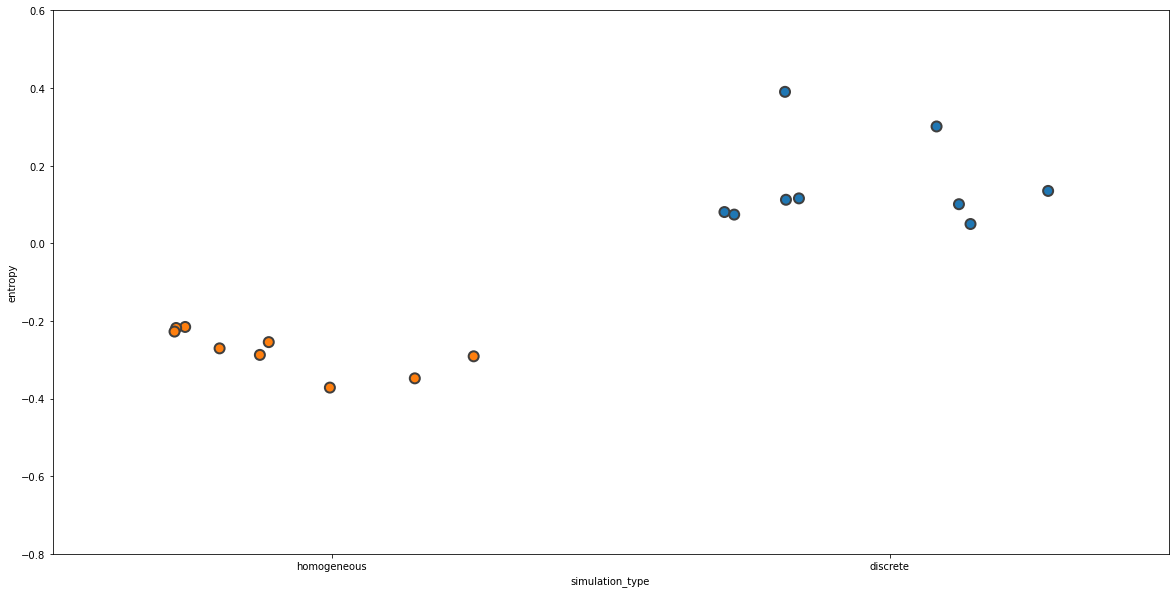

In [21]:
entropy_per_simulation_type = pd.DataFrame({'entropy':np.concatenate((average_entropy_per_sim_hom,average_entropy_per_sim_dis)),
                                            'simulation_type':np.concatenate((np.repeat('homogeneous',9),np.repeat('discrete',9)))
                                           } )

fig = plt.figure(figsize = (20,10))

ax = sns.stripplot(x = 'simulation_type', 
                   y = 'entropy', 
                   palette=["C1", "C0"],
                   data=entropy_per_simulation_type,
                   jitter=0.3,
                   size=10,
                   linewidth=2
                   
                  )

ax.set_ylim(-0.8,0.6)

fig.savefig("/".join((parent_folder,'cumulative_plots','entropy_asynchronous_AMPLITUDEONLY_scatter.pdf')))

### HWHM only

In [22]:
average_entropy_per_sim_hom = []

for simulation in all_data_separated['homogeneous_asynchronous']:
    temp_simulation_samples_hwhm = all_data_separated['homogeneous_asynchronous'][simulation].drop_duplicates(subset=['hwhm'])
    temp_simulation_samples_hwhm = temp_simulation_samples_hwhm[['hwhm']]
    temp_simulation_samples_hwhm = temp_simulation_samples_hwhm.loc[temp_simulation_samples_hwhm.hwhm!=1]

    entropy_temp = continuous.get_h(temp_simulation_samples_hwhm.to_numpy(),k=15)
    average_entropy_per_sim_hom.append(entropy_temp)

        
average_entropy_per_sim_hom


[-0.3185736164786799,
 -0.31301133404654546,
 -0.2823606936245704,
 -0.37887295560708045,
 -0.2864666703531782,
 -0.38115566503324994,
 -0.31477887371518953,
 -0.2671170113911061,
 -0.22894541926501732]

In [23]:
average_entropy_per_sim_dis = []

for simulation in all_data_separated['discrete_asynchronous']:
    temp_simulation_samples_hwhm = all_data_separated['discrete_asynchronous'][simulation].drop_duplicates(subset=['hwhm'])
    temp_simulation_samples_hwhm = temp_simulation_samples_hwhm[['hwhm']]
    temp_simulation_samples_hwhm = temp_simulation_samples_hwhm.loc[temp_simulation_samples_hwhm.hwhm!=1]

    
    temp_entropy_all = []
    for i in np.arange(0,100,1):
        subsample_idx_temp = np.random.randint(len(temp_simulation_samples_hwhm),size=211)
        subsample_temp = temp_simulation_samples_hwhm.to_numpy()
        subsample_temp = subsample_temp[subsample_idx_temp]
        entropy_temp = continuous.get_h(subsample_temp,k=15)
        temp_entropy_all.append(entropy_temp)
    average_entropy_per_sim_dis.append(np.mean(temp_entropy_all))

        
average_entropy_per_sim_dis




[0.2841675948916043,
 0.3006102489119226,
 0.31101950627190555,
 0.27761461802996307,
 0.25712064624369607,
 0.2358631655742964,
 0.31049174983757843,
 0.5229506613051798,
 0.4406427191533382]

In [24]:
print('HWHM ONLY\n')
print(''.join(('Mean hom:',str(np.mean(average_entropy_per_sim_hom)),' sem: ' ,str(sem(average_entropy_per_sim_hom)))))
print(''.join(('Mean dis:',str(np.mean(average_entropy_per_sim_dis)),' sem: ' ,str(sem(average_entropy_per_sim_dis)))))
print(''.join(('Entropy diff:',str(np.mean(average_entropy_per_sim_dis-np.mean(average_entropy_per_sim_hom))))))



wilcoxon(average_entropy_per_sim_hom,average_entropy_per_sim_dis)

HWHM ONLY

Mean hom:-0.3079202488349575 sem: 0.016499007417024775
Mean dis:0.3267201011354983 sem: 0.03117992570194515
Entropy diff:0.6346403499704558


WilcoxonResult(statistic=0.0, pvalue=0.00390625)

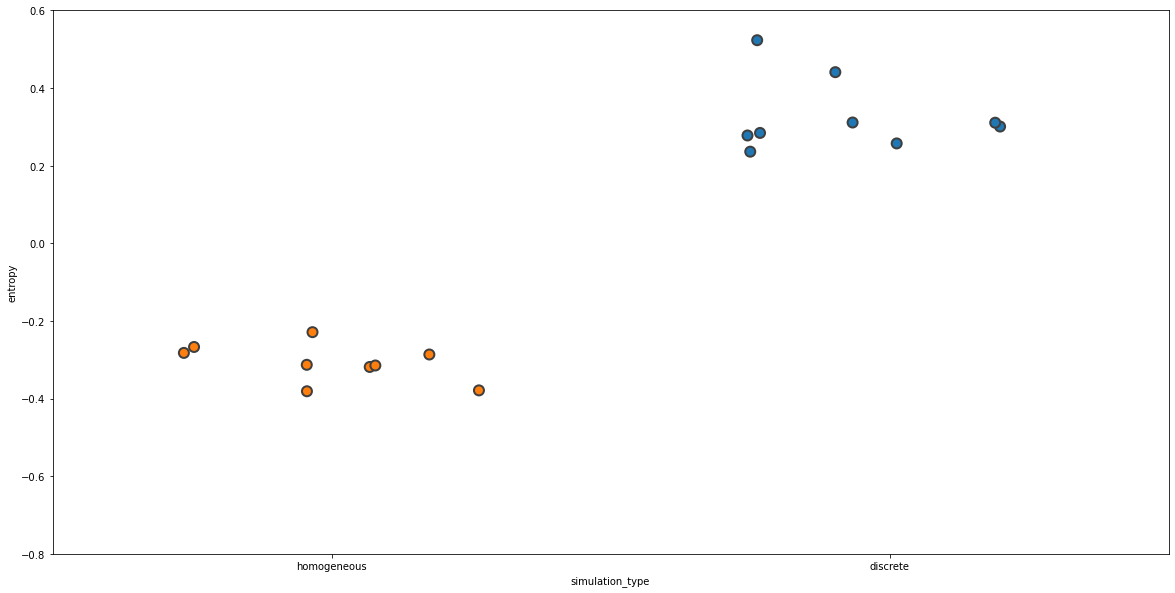

In [25]:
entropy_per_simulation_type = pd.DataFrame({'entropy':np.concatenate((average_entropy_per_sim_hom,average_entropy_per_sim_dis)),
                                            'simulation_type':np.concatenate((np.repeat('homogeneous',9),np.repeat('discrete',9)))
                                           } )

fig = plt.figure(figsize = (20,10))

ax = sns.stripplot(x = 'simulation_type', 
                   y = 'entropy', 
                   palette=["C1", "C0"],
                   data=entropy_per_simulation_type,
                   jitter=0.3,
                   size=10,
                   linewidth=2
                   
                  )

# ax.set_ylim(ylims)

ax.set_ylim(-0.8,0.6)

fig.savefig("/".join((parent_folder,'cumulative_plots','entropy_asynchronous_HWHMONLY_scatter.pdf')))